In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import os

import numpy as np
import cv2

from tqdm import tqdm

from albumentations.pytorch import ToTensorV2
import albumentations as A

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 0] = 0.0
    mask[(mask > 0.0)] = 1.0
    return mask

In [4]:
class KvasirDataset(Dataset):
    def __init__(self, path_dir_img, path_dir_mask, transform=None):
        self.transform = transform
        #IMG
        self.path_dir_img = path_dir_img
        self.dir_list_img = sorted(os.listdir(path_dir_img))
        #MASK
        self.path_dir_mask = path_dir_mask
        self.dir_list_mask = sorted(os.listdir(path_dir_mask))
        
    def __len__(self):
        return len(self.dir_list_img)
    
    def __getitem__(self, idx):
        #IMG
        img_path = os.path.join(self.path_dir_img, self.dir_list_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.0
        
        #MASK
        mask_path = os.path.join(self.path_dir_mask, self.dir_list_mask[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if len(mask.shape) == 3:
            mask = mask[:,:,1]
        mask = preprocess_mask(mask)
        
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]
        
        return {'img':img, 'mask':mask.unsqueeze(0)}
        

In [5]:
path_dir_img_train = 'D:/dataset/kvasir/train/images'
path_dir_mask_train = 'D:/dataset/kvasir/train/masks'

path_dir_img_test = 'D:/dataset/kvasir/test/sessile-main-Kvasir-SEG/images'
path_dir_mask_test = 'D:/dataset/kvasir/test/sessile-main-Kvasir-SEG/masks'

transform_train = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2()
    ]
)

transform_test = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2()
    ]
)

data_train = KvasirDataset(path_dir_img_train, path_dir_mask_train, transform=transform_train)
data_test = KvasirDataset(path_dir_img_test, path_dir_mask_test, transform=transform_test)

In [6]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(data_train, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(data_test, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=False)

{'img': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0

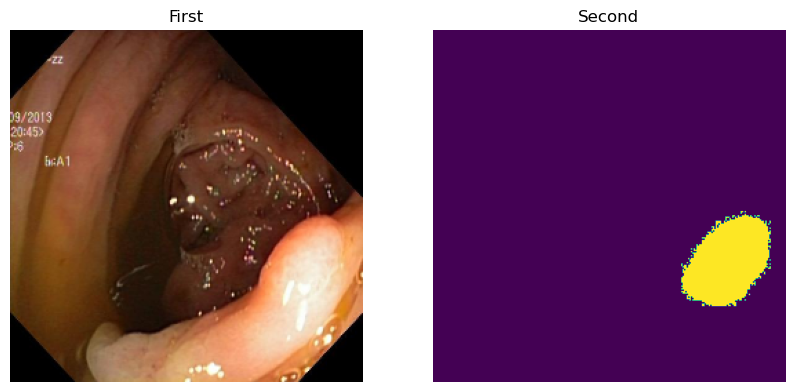

In [7]:
import matplotlib.pyplot as plt

data = data_test
id = 1

fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
plt.imshow(np.transpose(data[id]['img'], (1,2,0)))
plt.axis('off')
plt.title("First")

fig.add_subplot(rows, columns, 2)
plt.imshow(np.transpose(data[id]['mask'], (1,2,0)))
plt.axis('off')
plt.title("Second")

print(data[id])

In [8]:
class CNA(nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=True)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()
        
    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)
        
        return out

In [9]:
class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()
        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        _,_,h,w = x.shape
        inner = self.conv1(x)
        inner = self.conv2(inner)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)
        inner = F.upsample(inner, size=(h,w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        
        out = self.conv_cat(inner)
        
        return out

In [10]:
class Unet(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=6):
        super().__init__()
        
        self.cna1= CNA(3, nc)
        self.cna2= CNA(nc, nc)
        
        unetblock = None
        for i in range(num_downs-3):
            unetblock = UnetBlock(8*nc, 8*nc, 8*nc, unetblock)
        unetblock = UnetBlock(4*nc, 8*nc, 4*nc, unetblock)
        unetblock = UnetBlock(2*nc, 4*nc, 2*nc, unetblock)
        self.unetblock = UnetBlock(nc, 2*nc, nc, unetblock)
        
        self.cna3= CNA(nc, nc)
        
        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unetblock(out)
        out = self.cna3(out)
        out = self.conv_last(out)
        
        
        return out

In [11]:
device = 'cuda'
unet_model = Unet(in_nc=3, nc=32, out_nc=1, num_downs=4)
unet_model = unet_model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.0001)


In [40]:
epochs = 20

torch.cuda.empty_cache()

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        X, y = sample['img'], sample['mask']
        
        X = X.to(device)
        y = y.to(device)
        

        pred = unet_model(X)
        
        loss = loss_fn(pred, y)
        
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item
        
        optimizer.step()
        optimizer.zero_grad()
        
        pbar.set_description(f'loss: {loss_item:.5f}')
    
    #scheduler.step()
    
    print(f'epoch: {epoch + 1}')    
    print(f'loss: {loss_val/len(train_loader)}')

loss: 0.40159: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.40it/s]


epoch: 1
loss: 0.48546330871120574


loss: 0.35015: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.45it/s]


epoch: 2
loss: 0.37490990421464365


loss: 0.33587: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:24<00:00,  2.51it/s]


epoch: 3
loss: 0.309671463264573


loss: 0.27503: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:24<00:00,  2.48it/s]


epoch: 4
loss: 0.26824163621471775


loss: 0.17567: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.44it/s]


epoch: 5
loss: 0.2336188052450457


loss: 0.16963: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.45it/s]


epoch: 6
loss: 0.17875330967287864


loss: 0.11645: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.44it/s]


epoch: 7
loss: 0.14916209395854704


loss: 0.15770: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.46it/s]


epoch: 8
loss: 0.118048123414478


loss: 0.11973: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.40it/s]


epoch: 9
loss: 0.09969123657191953


loss: 0.08657: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.43it/s]


epoch: 10
loss: 0.0913896329941288


loss: 0.05876: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.42it/s]


epoch: 11
loss: 0.0717942995289641


loss: 0.05428: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.40it/s]


epoch: 12
loss: 0.06126734668449048


loss: 0.04492: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.43it/s]


epoch: 13
loss: 0.0538144511200728


loss: 0.04599: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.42it/s]


epoch: 14
loss: 0.052244011372808485


loss: 0.04175: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.43it/s]


epoch: 15
loss: 0.049013233953906644


loss: 0.03840: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:24<00:00,  2.51it/s]


epoch: 16
loss: 0.040752384661426465


loss: 0.03619: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:24<00:00,  2.51it/s]


epoch: 17
loss: 0.03948929683575707


loss: 0.05819: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:24<00:00,  2.51it/s]


epoch: 18
loss: 0.04228372757713641


loss: 0.04185: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:24<00:00,  2.51it/s]


epoch: 19
loss: 0.040847405400728024


loss: 0.02751: 100%|███████████████████████████████████████████████████████████████████| 62/62 [00:24<00:00,  2.50it/s]

epoch: 20
loss: 0.0359130708140231


In [43]:
id = 3
unet_model.eval()

print(data_test[id]['img'].shape)
mask_pred = unet_model(data_test[id]['img'].unsqueeze(0).to(device))
mask_pred = mask_pred.to('cpu').detach().numpy()
mask_pred = np.reshape(mask_pred, (256, 256))

torch.Size([3, 256, 256])


Text(0.5, 1.0, 'img')

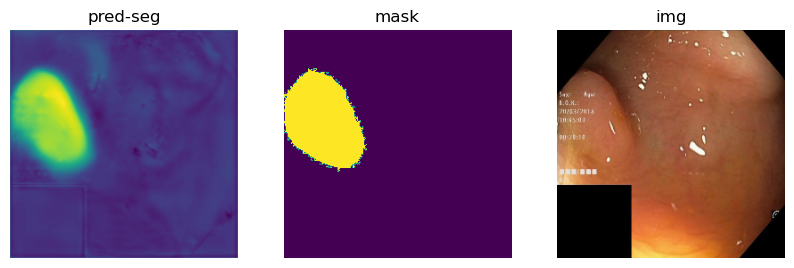

In [44]:
import matplotlib.pyplot as plt

data = data_test

fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 3
  
fig.add_subplot(rows, columns, 1)
plt.imshow(mask_pred)
plt.axis('off')
plt.title("pred-seg")

fig.add_subplot(rows, columns, 2)
plt.imshow(np.transpose(data[id]['mask'], (1,2,0)))
plt.axis('off')
plt.title("mask")

fig.add_subplot(rows, columns, 3)
plt.imshow(np.transpose(data[id]['img'], (1,2,0)))
plt.axis('off')
plt.title("img")

#print(data[id]['target'])